In [1]:
# Import necessary libraries

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils

from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

import itertools

import cv2
from PIL import Image

from google.colab import auth
import gspread
from google.auth import default

In [2]:
# Mount the drive into google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dataset selection
DATASET_CHOICE = 'none_aug_dataset/dataset_701515'

# Dataset path for each type of breast cancer
benign_path_train    = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/train/benign'
malignant_path_train = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/train/malignant'
normal_path_train    = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/train/normal'

benign_path_test     = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/test/benign'
malignant_path_test  = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/test/malignant'
normal_path_test     = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/test/normal'

benign_path_val      = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/val/benign'
malignant_path_val   = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/val/malignant'
normal_path_val      = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/val/normal'


# List all images of each dataset
benign_images_train    = os.listdir(benign_path_train)
malignant_images_train = os.listdir(malignant_path_train)
normal_images_train    = os.listdir(normal_path_train)

benign_images_test     = os.listdir(benign_path_test)
malignant_images_test  = os.listdir(malignant_path_test)
normal_images_test     = os.listdir(normal_path_test)

benign_images_val      = os.listdir(benign_path_val)
malignant_images_val   = os.listdir(malignant_path_val)
normal_images_val      = os.listdir(normal_path_val)

# Set picture size
pic_size = 256


# Scenario 1
# train_images = [benign_images_train, normal_images_train]
# test_images  = [benign_images_test,  normal_images_test]
# val_images   = [benign_images_val,   normal_images_val]

# train_path   = [benign_path_train, normal_path_train]
# test_path    = [benign_path_test,  normal_path_test]
# val_path     = [benign_path_val,   normal_path_val]


# Scenario 2
# train_images = [malignant_images_train, normal_images_train]
# test_images  = [malignant_images_test,  normal_images_test]
# val_images   = [malignant_images_val,   normal_images_val]

# train_path   = [malignant_path_train, normal_path_train]
# test_path    = [malignant_path_test,  normal_path_test]
# val_path     = [malignant_path_val,   normal_path_val]


# Scenario 3
train_images = [benign_images_train, malignant_images_train, normal_images_train]
test_images  = [benign_images_test, malignant_images_test, normal_images_test]
val_images   = [benign_images_val, malignant_images_val, normal_images_val]

train_path   = [benign_path_train, malignant_path_train, normal_path_train]
test_path    = [benign_path_test, malignant_path_test, normal_path_test]
val_path     = [benign_path_val, malignant_path_val, normal_path_val]


# Set plot to visualize loaded image

def split_train_test_validation(list_img, path):
  images = []
  labels = []
  index = 0
  for img_type in list_img:
    for i in img_type:
      img = cv2.imread(os.path.join(path[index], i))
      img = cv2.resize(img, (pic_size, pic_size))
      img = img.astype(np.float32) / 255.
      images.append(img)
      labels.append(index) 
    index += 1
  return np.stack(images, axis=0), np.array(labels)

# Store the value of x and y for training, testing, and validating
x_train, y_train = split_train_test_validation(train_images, train_path)
x_test , y_test  = split_train_test_validation(test_images, test_path)
x_val  , y_val   = split_train_test_validation(val_images, val_path)

In [4]:
# Store the train_val_test tuple
train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

In [5]:
[x_train.shape, x_val.shape, x_test.shape , y_train.shape , y_val.shape , y_test.shape]

[(545, 256, 256, 3),
 (118, 256, 256, 3),
 (117, 256, 256, 3),
 (545,),
 (118,),
 (117,)]

**Run the proposed model**

In [6]:
class Original_CNN(object):
    
    '''
    @param data dataset after split/preprocessing.
    @param architecture for what kind of neutral network model to be use.
    @param hidden_layers for modify value to preprocess.
    @param classes for how many classification to be make.
    @param epoch for how many batch need to split from dataset.
    @param batch_size for how many item in a batch.
    '''
    def __init__(self, data, architecture, classes, epochs, batch_size): 
        
        self.input_shape = data[0][0].shape             # Create a shape of numpy array.

        self.base_arch = architecture                   # Set network model.
        self.nn = self.download_network()               # Download neutral network model.
        self.classes = classes                          # Set number of classification.

        # Set data from numpy array
        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        # Set epoch and batch size
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        # Build and start augmentation data.
        self.model = self.build()

        self.predictions = None
        self.score = None
        self.model_history = None

    # Get neutral network model base on what kind of model have been chosen.
    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        y_pred = self.train_model()
        return y_pred

    def build(self):
        model = tf.keras.models.Sequential()                                    # Groups a linear stack of layers into model.
        model.add(self.nn)                                                      # Add neutral network model.
        model.add(tf.keras.layers.Flatten())                                    # Flatten

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))    # Activation='softmax' converts a vector of values to a probability distribution.
        
        print(model.summary())

        return model
    
    def train_model(self):
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

        num_training_samples = self.trainX.shape[0]

        self.model_history = self.model.fit(
            x_train, y_train,
            steps_per_epoch=num_training_samples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
        )

        # Store the best accuracy
        best_acc = max(self.model_history.history["accuracy"])
        print('\nMax accuracy:', best_acc)

        # Store the best validation accuracy
        best_val_acc = max(self.model_history.history["val_accuracy"])
        print('\nMax validation accuracy:', best_val_acc)

        y_pred = self.predict_score()

    def predict_score(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')
        return self.predictions

    def write_result_to_ggsheet(self, cell_acc, cell_loss, cell_test):
        
        auth.authenticate_user()
        creds, _ = default()

        gc = gspread.authorize(creds)

        worksheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1EvTMbQfiw0eRLezk-YepDDTf04qfnrQWyGf072B6i_g/edit?usp=sharing").worksheets()[0]

        cell_list = worksheet.range(cell_acc) + worksheet.range(cell_loss) + worksheet.range(cell_test)

        # Store the evaluating scores at the 5th, 10th, 15th, 20th, and 25th epoch
        list_training_acc  = self.model_history.history["accuracy"][4::5]
        list_val_acc       = self.model_history.history["val_accuracy"][4::5]
        
        list_training_loss = self.model_history.history["loss"][4::5]
        list_val_loss      = self.model_history.history["val_loss"][4::5]

        test_loss          = [self.score[0]]
        test_acc           = [self.score[1]]

        list_data = list_training_acc + list_val_acc + list_training_loss + list_val_loss + test_loss + test_acc


        # Write all the data into the gg sheet
        pos = 0
        for cell in cell_list:
            cell.value = round(list_data[pos], 4)
            pos += 1

        worksheet.update_cells(cell_list)

    def calculate_metrics(self):
        training_acc = max(self.model_history.history["accuracy"])
        print("\nTraining accuracy: {}".format(training_acc))

        val_acc = max(self.model_history.history["val_accuracy"])
        print("\nValidation accuracy: {}".format(val_acc))

        loss = min(self.model_history.history["loss"])
        print("\nTraining loss: {}".format(loss))

        val_loss = min(self.model_history.history["val_loss"])
        print("\nValidation loss: {}".format(val_loss))

        # predict probabilities for test set
        probs = self.model.predict(self.testX, verbose=0)
        # predict crisp classes for test set
        classes = np.argmax(probs, axis=1)

        y_true = self.testY
        y_pred = classes

        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y_true, y_pred)
        print("\nACC:       {}".format(accuracy))

        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print("F1:        {}".format(f1))

    def save_model(self):
        self.model.save('/content/drive/My Drive/Research/ungthuvu/model/demo_model.h5')

    

In [7]:
# list_architecture = ['VGG16', 'VGG19', 'InceptionV3', 'MobileNet']
base_arch = 'MobileNet'
CLASSES       = 3
BATCH_SIZE    = 64
EPOCHS        = 30

# Positions that need to be written in google sheet
# cell_acc  = 'C10:L10'
# cell_loss = 'C23:L23'
# cell_test = 'C36:D36'

model = Original_CNN(
            data=train_val_test, 
            architecture=base_arch, 
            classes=CLASSES, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE
        )

model.run()
model.calculate_metrics()
model.save_model()


# model.write_result_to_ggsheet(cell_acc=cell_acc, cell_loss=cell_loss, cell_test=cell_test)


17235968/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 3)                 196611    
                                                                 
Total params: 3,425,475
Trainable params: 3,403,587
Non-trainable params: 21,888
_________________________________________________________________
None
Epoch 1/30
8/8 [==============================] - 24s 1s/step - loss: 2.1697 - accuracy: 0.4862 - val_loss: 1.7117 - val_accuracy: 0.3644
Epoch 2/30
8/8 [===============

**Build and run the proposed model**

In [ ]:
class Tuner(object):
    
    '''
    @param data dataset after split/preprocessing.
    @param architecture for what kind of neutral network model to be use.
    @param hidden_layers for modify value to preprocess.
    @param classes for how many classification to be make.
    @param epoch for how many batch need to split from dataset.
    @param batch_size for how many item in a batch.
    '''
    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size): 
        
        self.input_shape = data[0][0].shape             # Create a shape of numpy array.

        self.base_arch = architecture                   # Set network model.
        self.nn = self.download_network()               # Download neutral network model.
        self.classes = classes                          # Set number of classification.

        self.nn.trainable = False                       # Freeze all layers in the base model
        self.hidden_layers = hidden_layers              # Set hidden_layers.


        # Set data from numpy array
        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        # Set epoch and batch size
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        # Build and start augmentation data.
        self.model = self.build()

        self.predictions = None
        self.score = None
        self.model_history = None
        self.best_weights = None

    # Get neutral network model base on what kind of model have been chosen.
    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        y_pred = self.fine_tune()
        return y_pred

    def build(self):
        # model = tf.keras.models.Sequential()                   # Groups a linear stack of layers into model.
        # model.add(self.nn)                                     # Add neutral network model (freeze all layers of the transfer learning model)
        # model.add(tf.keras.layers.Flatten())                   # Convert the data into a 1-dimensional array for inputting it to the next layer
        # model.add(tf.keras.layers.Dropout(0.2))                # Add Dropout to prevent overfitting
        
        # for layer in self.hidden_layers:
        #     model.add(tf.keras.layers.Dense(layer, activation='relu'))          # Activation='relu' applies the rectified linear unit activation function.
        #     model.add(tf.keras.layers.BatchNormalization())                     # Maintains the mean output close to 0 and the output standard deviation close to 1
        #     model.add(tf.keras.layers.Dropout(0.25))                            # Add Dropout to prevent overfitting

        # model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))    # Activation='softmax' converts a vector of values to a probability distribution.
        
        # print(model.summary())

        base_model=tf.keras.applications.MobileNet(
            weights='imagenet',
            input_shape=(256,256,3),
            include_top=False
        )

        x = base_model.output

        x = keras.layers.Flatten()(x)
        x = keras.layers.Dropout(0.2)(x)

        for layer in self.hidden_layers:
            x = keras.layers.Dense(layer)(x)
            x = keras.layers.Activation(activation='relu')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dropout(0.25)(x)

        x = keras.layers.Dense(self.classes)(x)
        x = keras.layers.Activation(activation='softmax')(x)

        model=keras.Model(inputs=base_model.input,outputs=x)

        for layer in base_model.layers:
            layer.trainable = False
        
        #print(model.summary())
        return model

        
        # x=keras.layers.GlobalAveragePooling2D()(x)
        # x=keras.layers.Dense(1024)(x)
        # x=keras.layers.Activation(activation='relu')(x)
        # x= keras.layers.Dropout(0.5)(x)

        # x=keras.layers.Dense(512)(x)
        # x=keras.layers.Activation(activation='relu')(x)
        # x= keras.layers.Dropout(0.5)(x)

        # x=keras.layers.Dense(256)(x)
        # x=keras.layers.Activation(activation='relu')(x)
        # x= keras.layers.Dropout(0.5)(x)

        # x=keras.layers.Dense(6)(x)
        # x=keras.layers.Activation(activation='softmax')(x)

        # model=keras.Model(inputs=base_model.input,outputs=x)

        # ############### Start Compile ###############
        # model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        #             loss=tf.keras.losses.CategoricalCrossentropy(),
        #             metrics=['accuracy'])
        # ############### End Compile ###############

        # # frezze pre-train model
        # for layer in base_model.layers:
        #     layer.trainable = False
        return model
    
    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''
        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        self.model_history = self.model.fit(
            x_train, y_train,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            callbacks=[checkpoint])
        
        # print(self.valX, self.valY)

        # Store the best phase 1 accuracy
        best_acc_ph1 = max(self.model_history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        y_pred=self.predict_score()

        self.plot_loss(self.model_history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch)
        self.plot_acc(self.model_history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch)

        self.calculate_metrics()

    def predict_score(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')
        return self.predictions

    def plot_loss(self, model_history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss", )
        plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
        plt.title("Training Loss - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def plot_acc(self, model_history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), model_history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], label="val_acc")
        plt.title("Training Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    def calculate_metrics(self):
        
        training_acc = max(self.model_history.history["accuracy"])
        print("\nTraining accuracy: {}".format(training_acc))

        val_acc = max(self.model_history.history["val_accuracy"])
        print("\nValidation accuracy: {}".format(val_acc))

        loss = min(self.model_history.history["loss"])
        print("\nTraining loss: {}".format(loss))

        val_loss = min(self.model_history.history["val_loss"])
        print("\nValidation loss: {}".format(val_loss))

        # predict probabilities for test set
        probs = self.model.predict(self.testX, verbose=0)
        # predict crisp classes for test set
        classes = np.argmax(probs, axis=1)

        y_true = self.testY
        y_pred = classes

        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y_true, y_pred)
        print("\nACC:       {}".format(accuracy))

        # precision tp / (tp + fp)
        # precision = precision_score(y_true, y_pred, average='weighted')
        # print("Precision: {}".format(precision))

        # recall: tp / (tp + fn)
        # recall = recall_score(y_true, y_pred, average='weighted')
        # print("Recall:    {}".format(recall))

        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print("F1:        {}".format(f1))

        # fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
        # auc_score = auc(fpr, tpr)
        # print("AUC:       {}".format(auc_score))

        # mcc_score = matthews_corrcoef(y_true, y_pred)
        # print("MCC:       {}".format(matthews_corrcoef(y_test, y_pred)))

        print('\n')

        # target_names = ['malignant', 'normal']
        # target_names = ['benign',    'normal']
        target_names = ['benign', 'malignant', 'normal']
        print(classification_report(y_true, y_pred, target_names=target_names))

        print('\n')
        cnf_matrix = confusion_matrix(y_test, y_pred)
        print(cnf_matrix)
        np.set_printoptions(precision=2)

        # plot normalized confusion matrix
        plt.figure()
        self.plot_confusion_matrix(cnf_matrix, classes=target_names, title='Normalized confusion matrix')
        plt.show()


    def plot_confusion_matrix(self, cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(10,10))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

    def save_model(self):
        self.model.save('/content/drive/My Drive/Research/ungthuvu/model/model.h5')

    def write_result_to_ggsheet(self, cell_acc, cell_loss, cell_test):
        
        auth.authenticate_user()
        creds, _ = default()

        gc = gspread.authorize(creds)

        worksheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1EvTMbQfiw0eRLezk-YepDDTf04qfnrQWyGf072B6i_g/edit?usp=sharing").worksheets()[0]

        cell_list = worksheet.range(cell_acc) + worksheet.range(cell_loss) + worksheet.range(cell_test)

        # Store the evaluating scores at the 10th, 20th, 30th
        list_training_acc  = self.model_history.history["accuracy"][9::10]
        list_val_acc       = self.model_history.history["val_accuracy"][9::10]
        
        list_training_loss = self.model_history.history["loss"][9::10]
        list_val_loss      = self.model_history.history["val_loss"][9::10]

        test_loss          = [self.score[0]]
        test_acc           = [self.score[1]]

        list_data = list_training_acc + list_val_acc + list_training_loss + list_val_loss + test_loss + test_acc


        # Write all the data into the gg sheet
        pos = 0
        for cell in cell_list:
            cell.value = round(list_data[pos], 4)
            pos += 1

        worksheet.update_cells(cell_list)



In [ ]:
base_arch     = 'MobileNet'
CLASSES       = 3
BATCH_SIZE    = 64
EPOCHS        = 30
HIDDEN_LAYERS = [256, 256, 64]


# Positions that need to be written in google sheet
# cell_acc  = 'C4:H4'
# cell_loss = 'C13:H13'
# cell_test = 'C22:D22'

acc = 0
while (acc < 0.9):
    model = Tuner(data=train_val_test, architecture=base_arch, hidden_layers=HIDDEN_LAYERS, classes=CLASSES, epochs=EPOCHS, batch_size=BATCH_SIZE)
    model.run()
    acc = model.score[1]
# model.write_result_to_ggsheet(cell_acc=cell_acc, cell_loss=cell_loss, cell_test=cell_test)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.save_model()
# [0.30642956495285034, 0.9145299196243286]

GradCAM

Image 1
normal (0.8763)
benign (0.1169)
malignant (0.006784)

Image 2
normal (0.5405)
benign (0.4121)
malignant (0.04737)

Image 3
normal (0.8938)
malignant (0.08565)
benign (0.02056)

Image 4
normal (0.9995)
malignant (0.0004477)
benign (2.122e-05)

Image 5
normal (0.9992)
malignant (0.0006829)
benign (0.0001082)

Image 6
normal (0.9617)
malignant (0.03703)
benign (0.001267)

Image 7
normal (0.9691)
benign (0.02401)
malignant (0.006926)

Image 8
normal (0.8769)
benign (0.1135)
malignant (0.00961)

Image 9
normal (0.848)
benign (0.1451)
malignant (0.006977)

Image 10
benign (0.7317)
normal (0.1841)
malignant (0.08428)

Image 11
benign (0.682)
normal (0.2944)
malignant (0.02355)

Image 12
normal (0.6308)
benign (0.3562)
malignant (0.01294)

Image 13
normal (0.6427)
benign (0.1913)
malignant (0.1659)

Image 14
normal (0.5417)
benign (0.3266)
malignant (0.1317)

Image 15
normal (0.9796)
malignant (0.02026)
benign (9.09e-05)

Image 16
normal (0.9874)
malignant (0.00807)
benign (0.004483)



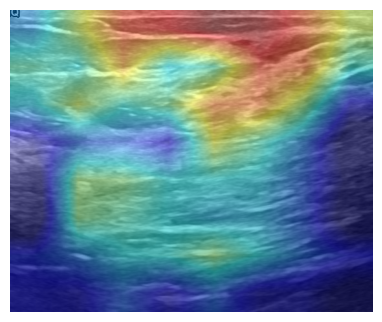

In [ ]:
from keras.preprocessing                  import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.mobilenet         import preprocess_input
from keras.models                         import Model
import io
import base64

# Load proposed model
model = keras.models.load_model('/content/drive/My Drive/Research/ungthuvu/model/model.h5')

# print(model.summary())
DATASET_CHOICE = 'none_aug_dataset/dataset_701515'
pic_size = 256

def process_image(img_path):

    # Load the image based on the provided path with the target size
    img = image.load_img(img_path, target_size=(pic_size, pic_size))
    
    # Convert image to numpy array of shape (256, 256, 3)
    x_img = image.img_to_array(img)

    # Transform the image array into a matrix of shape (1, 256, 256, 3)
    x_img = np.expand_dims(x_img, axis=0)

    # Preprocess the batch (channel-wise color normalization)
    x_img = preprocess_input(x_img)
    
    return x_img


def print_predicted_result(img):
    pred = model.predict(img)
    y_classes = [np.argmax(element) for element in pred]
    label_classes = ['benign', 'malignant', 'normal']
    sorted_category = np.argsort(pred[0])[:-4:-1]
    data_result = {}
    for i in range(3):
        print("{}".format(label_classes[sorted_category[i]]) + " ({:.4})".format(pred[0][sorted_category[i]]))
        data_result.update({label_classes[sorted_category[i]]:pred[0][sorted_category[i]] * 100})
    y_pred = label_classes[y_classes[0]]

    # print("Our proposed model is {:.2%}".format(max(pred[0])) + " sure this is {}".format(y_pred))
    # print(data_result, list(data_result.keys())[0])
    return data_result, list(data_result.keys())[0]



def gradcam(img_path):
    x_img = process_image(img_path)
    print_predicted_result(x_img)

    img_sample = cv2.imread(img_path)
    #plt.rcParams['figure.figsize'] = (8, 8)


    # Get the output feature map from the target layer
    target_layer = model.get_layer("conv_pw_13_relu")
    # target_layer = model.get_layer("mobilenet_1.00_224")

    prediction = model.predict(x_img)
    prediction_idx = np.argmax(prediction)

    # Fix gradient error
    with tf.GradientTape() as tape:
          # Create a model with original model inputs and the last conv_layer as the output
          gradient_model = Model([model.inputs], [target_layer.output, model.output])
          # Pass the image through the base model and get the feature map  
          conv2d_out, prediction = gradient_model(x_img)
          # Prediction loss
          loss = prediction[:, prediction_idx]

    # gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    test_img = cv2.imread(img_path)


    original_img = np.asarray(test_img, dtype = np.float32)

    # Resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                original_img.shape[0]))
    
    # Ensure no negative number
    activation_map = np.maximum(activation_map, 0)

    # Convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    
    # Rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)
    
    # Convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)
    plt.rcParams["figure.dpi"] = 100
    interpolant=0.6
    
    #plt.margins(x=0)

    plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    plt.axis("off")
    plt.savefig('gradcam.png', transparent=True, bbox_inches='tight')

    with open('gradcam.png', "rb") as img_file:
        b64_string = base64.b64encode(img_file.read())
        image_base64 = b64_string.decode()
        os.remove('gradcam.png')
        return image_base64
    

img_path = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/test/normal/normal_(5).png'
#base64_gradcam_img = gradcam(img_path)

for i in range(1, 21):
    print('Image ' + str(i))
    img_path = '/content/drive/My Drive/Research/ungthuvu/' + DATASET_CHOICE + '/test/normal/normal_(' + str(i) + ').png'
    base64_gradcam_img = gradcam(img_path)
    print()
